In [23]:
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.patches as mpatches
import matplotlib.lines as mlines 


In [2]:
path = '/home/dkabe/Model_brainstorming/Output/Variable_vals/'

In [3]:
Manufacturing_plants = 6
Distribution = 4
Market = 29
num_Scenarios = 128
Products = 3
Outsourced = 3
rl = [0.5, 0.95]
r_level = 0.5

In [4]:
demand = np.loadtxt('/home/dkabe/Model_brainstorming/Input_Data/Realistic/Instance_1/Demand_1.txt').reshape((128, 3, 29))
text_file = open('/home/dkabe/Model_brainstorming/Input_Data/Realistic/Instance_1/scen_1.txt', "r")
ls = text_file.read().split('\n')[:-1]
Scen = list(map(lambda x: ast.literal_eval(x), ls))
f = open(path + "Instance_1/variable_vals_" +str(r_level) + ".txt", "r")
text = f.read()
f.close()
solutions_str = text.split('\n')
for i in solutions_str:
    exec(i.lstrip().rstrip())

In [5]:
print(v_val_x_i)
print(v_val_x_j)

{0: -0.0, 1: 1.0, 2: -0.0, 3: 1.0, 4: 1.0, 5: -0.0}
{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}


In [6]:
indices = [21, 56]
for index in indices:
    print(Scen[index])

[[1, 1, 1, 1, 0, 0], (1, 0, 1, 0)]
[[1, 1, 0, 0, 0, 0], (0, 1, 1, 1)]


/home/dkabe/env_gurobi/lib/python3.7/site-packages/ipykernel_launcher.py:143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


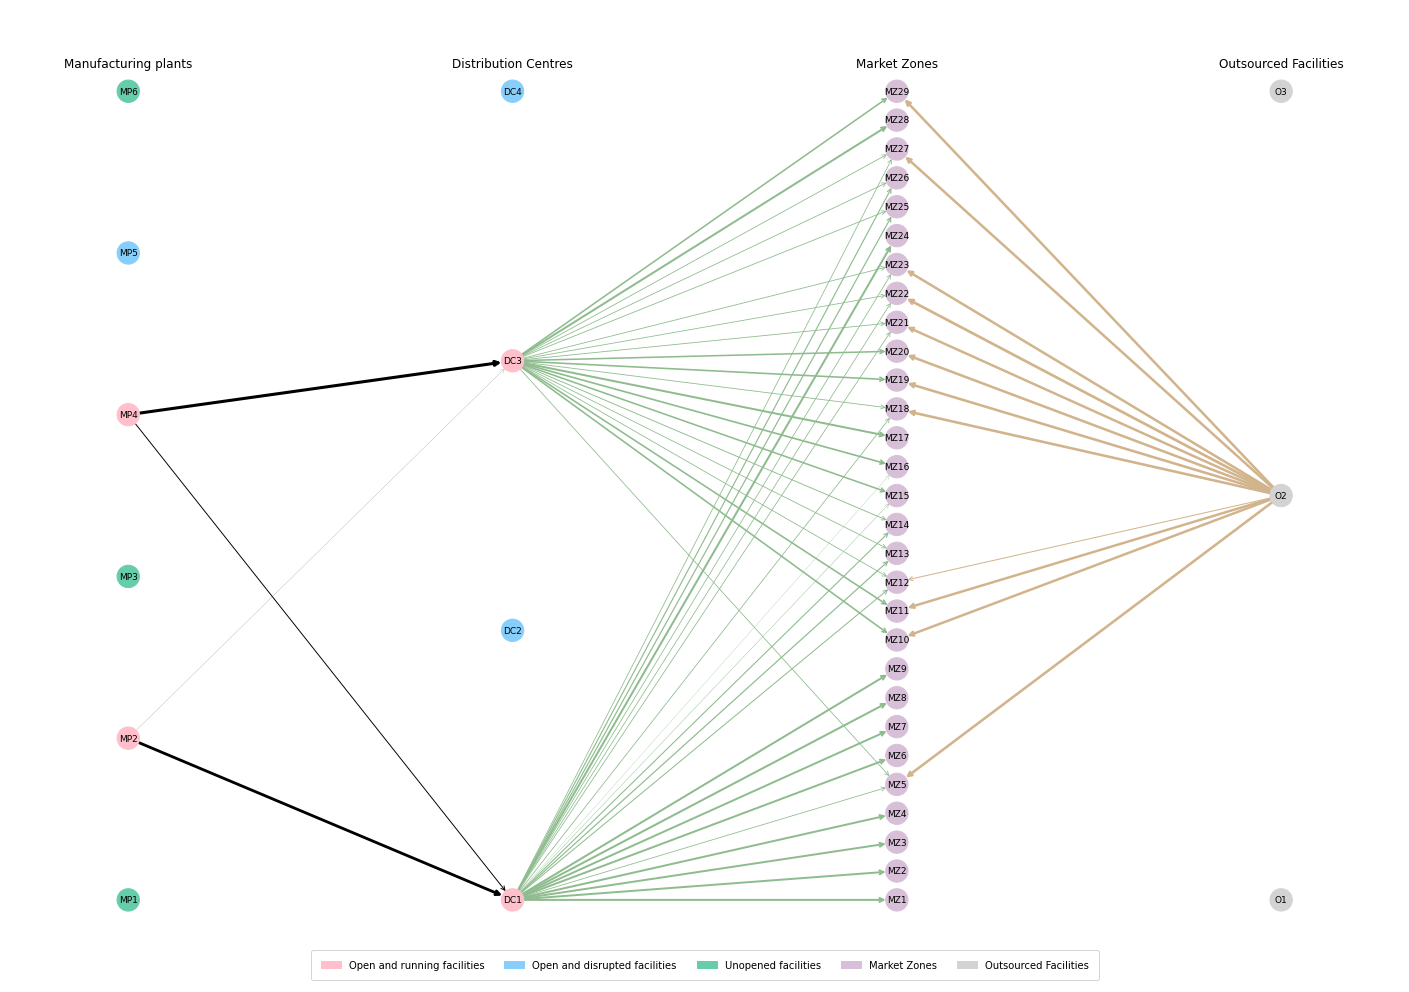

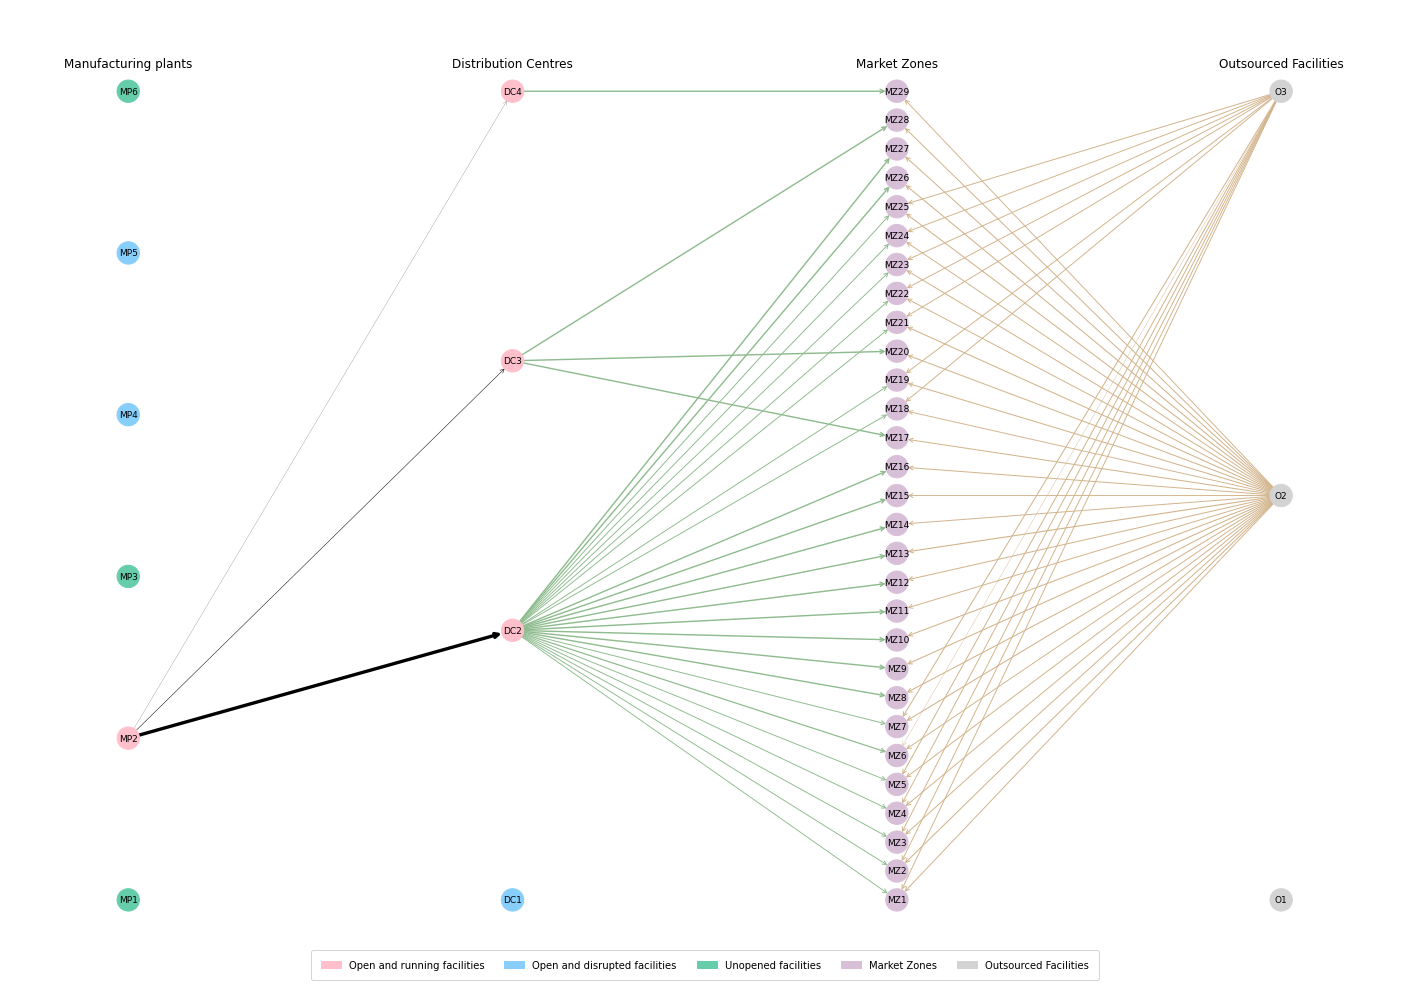

In [55]:
for index in indices:
    
    Y_mat = np.array(list(v_val_Y_ijm.values())).reshape(num_Scenarios, Products, Manufacturing_plants, Distribution)
    Z_mat = np.array(list(v_val_Z_jkm.values())).reshape(num_Scenarios, Products, Distribution, Market)
    T2_mat = np.array(list(v_val_T_lkm.values())).reshape(num_Scenarios, Products, Outsourced, Market)

    Y = sum(Y_mat[index])
    Z = sum(Z_mat[index])
    T2 = sum(T2_mat[index])

    MP = ["MP" + str(i+1) for i in range(Manufacturing_plants)]
    DC = ["DC" + str(j+1) for j in range(Distribution)]
    MZ = ["MZ" + str(k+1) for k in range(Market)]
    O = ["O" + str(l+1) for l in range(Outsourced)]

    Position_dic = {}
    Node_colors = []
    Edge_colors = []
    Node_size = []
    Weight = []
    Weight_ij = []
    Weight_jk = []
    Weight_lk = []
    Max_p = max(Manufacturing_plants, Distribution, Market, Outsourced)

    IJ_edges = []
    for i in range(Manufacturing_plants):
        for j in range(Distribution):
            #if Y[i][j] > 0:
            IJ_edges.append(("MP" + str(i+1), "DC" + str(j+1)))    
    Weight_ij.extend(Y.sum(axis=1))
        
    JK_edges = []
    for j in range(Distribution):
        for k in range(Market):
            #if Z[j][k] > 0:
            JK_edges.append(("DC" + str(j+1), "MZ" + str(k+1)))
    Weight_jk.extend(Z.sum(axis=1))

    LK_edges = []
    for l in range(Outsourced):
        for k in range(Market):
            #if Tlk[l][k] > 0:
            LK_edges.append(("O" + str(l+1), "MZ" + str(k+1)))    
    Weight_lk.extend(T2.sum(axis = 1))

    Weight.extend([4*Y[i][j]/max(Weight_ij) for i in range(Manufacturing_plants) for j in range(Distribution)])
    Weight.extend([29*Z[j][k]/max(Weight_jk) for j in range(Distribution) for k in range(Market)])
    Weight.extend([29*T2[l][k]/max(Weight_lk) for l in range(Outsourced) for k in range(Market)])        

                
    Graph = nx.DiGraph()

    Position_values = []
    y_pos = np.linspace(0, Max_p, Manufacturing_plants)
    for i in range(Manufacturing_plants):
        position = (0, y_pos[i])        
        Graph.add_node(MP[i])
        if v_val_x_i[i] == 1 and Scen[index][0][i] == 1:
            Node_colors.append('pink')
        elif v_val_x_i[i] == 1 and Scen[index][0][i] == 0:
            Node_colors.append('lightskyblue')
        else:
            Node_colors.append("mediumaquamarine")
        Position_values.append(np.asarray(position))
    Position_dic = dict(zip(MP, Position_values))

    Position_values = []
    y_pos = np.linspace(0, Max_p, Distribution)
    for j in range(Distribution):
        position = (1, y_pos[j])
        Graph.add_node(DC[j])
        if v_val_x_j[j] == 1 and Scen[index][1][j] == 1:
            Node_colors.append('pink')
        elif v_val_x_j[j] == 1 and Scen[index][1][j] == 0:
            Node_colors.append('lightskyblue')
        else:
            Node_colors.append("mediumaquamarine")
        Position_values.append(np.asarray(position))
    Position_dic.update(dict(zip(DC, Position_values)))

    Position_values = []
    y_pos = np.linspace(0, Max_p, Market)
    for k in range(Market):
        position = (2, y_pos[k])
        Graph.add_node(MZ[k])
        Node_colors.append('thistle')
        Position_values.append(np.asarray(position))
    Position_dic.update(dict(zip(MZ, Position_values)))

  
    Position_values = []
    y_pos = np.linspace(0, Max_p, Outsourced)
    for l in range(Outsourced):
        position = (3, y_pos[l])
        Graph.add_node(O[l])
        Node_colors.append('lightgrey')
        Position_values.append(np.asarray(position))
    Position_dic.update(dict(zip(O, Position_values)))

    # Add Edges

    Graph.add_edges_from(IJ_edges)
    Graph.add_edges_from(JK_edges)
    Graph.add_edges_from(LK_edges)


    Edge_colors.extend(['black' for i in IJ_edges])
    Edge_colors.extend(['darkseagreen' for i in JK_edges])
    Edge_colors.extend(['tan' for l in LK_edges])


    nodePos = nx.shell_layout(Graph)
    nx.draw_networkx(Graph, with_labels = True, font_size = 9, font_color = "black", node_size = 500, node_color = Node_colors, edge_color = Edge_colors, pos = Position_dic, width = Weight, arrows=True, arrowstyle = '->')
    
    # Add Titles (invisible nodes to put text labels)
    position_mp = (0, 30)
    position_dc = (1, 30)
    position_mz = (2, 30)
    position_o = (3, 30)
    position_titles = [np.asarray(position_mp), np.asarray(position_dc), np.asarray(position_mz), np.asarray(position_o)]
    Graph.add_node("Manufacturing Plants")
    Graph.add_node("Distribution Centres")
    Graph.add_node("Market Zones")
    Graph.add_node("Outsourced Facilities")
    titles = ["Manufacturing plants", "Distribution Centres", "Market Zones", "Outsourced Facilities"]
    title_pos = dict(zip(titles, position_titles))
    label_titles = {}    
    for node in titles:
        label_titles[node] = node
    nx.draw_networkx_nodes(Graph, nodelist= titles, pos = title_pos, node_color = "white")
    nx.draw_networkx_labels(Graph, labels = label_titles, pos = title_pos, font_color = "black", font_size = 12)

    limits=plt.axis('off')
    plt.gcf().set_size_inches(25, 18)

    legend_mp_1 = mpatches.Patch(color = 'pink', label = 'Open and running facilities')
    legend_mp_2 = mpatches.Patch(color = 'lightskyblue', label = 'Open and disrupted facilities')
    legend_mp_3 = mpatches.Patch(color = 'mediumaquamarine', label = 'Unopened facilities')
    legend_mz = mpatches.Patch(color = 'thistle', label = 'Market Zones')
    legend_o = mpatches.Patch(color = 'lightgrey', label = 'Outsourced Facilities')

    ax = plt.subplot(111)
    ax.legend(loc = 'lower center', handles=[legend_mp_1, legend_mp_2, legend_mp_3, legend_mz, legend_o], ncol = 5, borderpad=1)

    plt.show()

In [8]:
## Without color

/home/dkabe/env_gurobi/lib/python3.7/site-packages/ipykernel_launcher.py:151: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


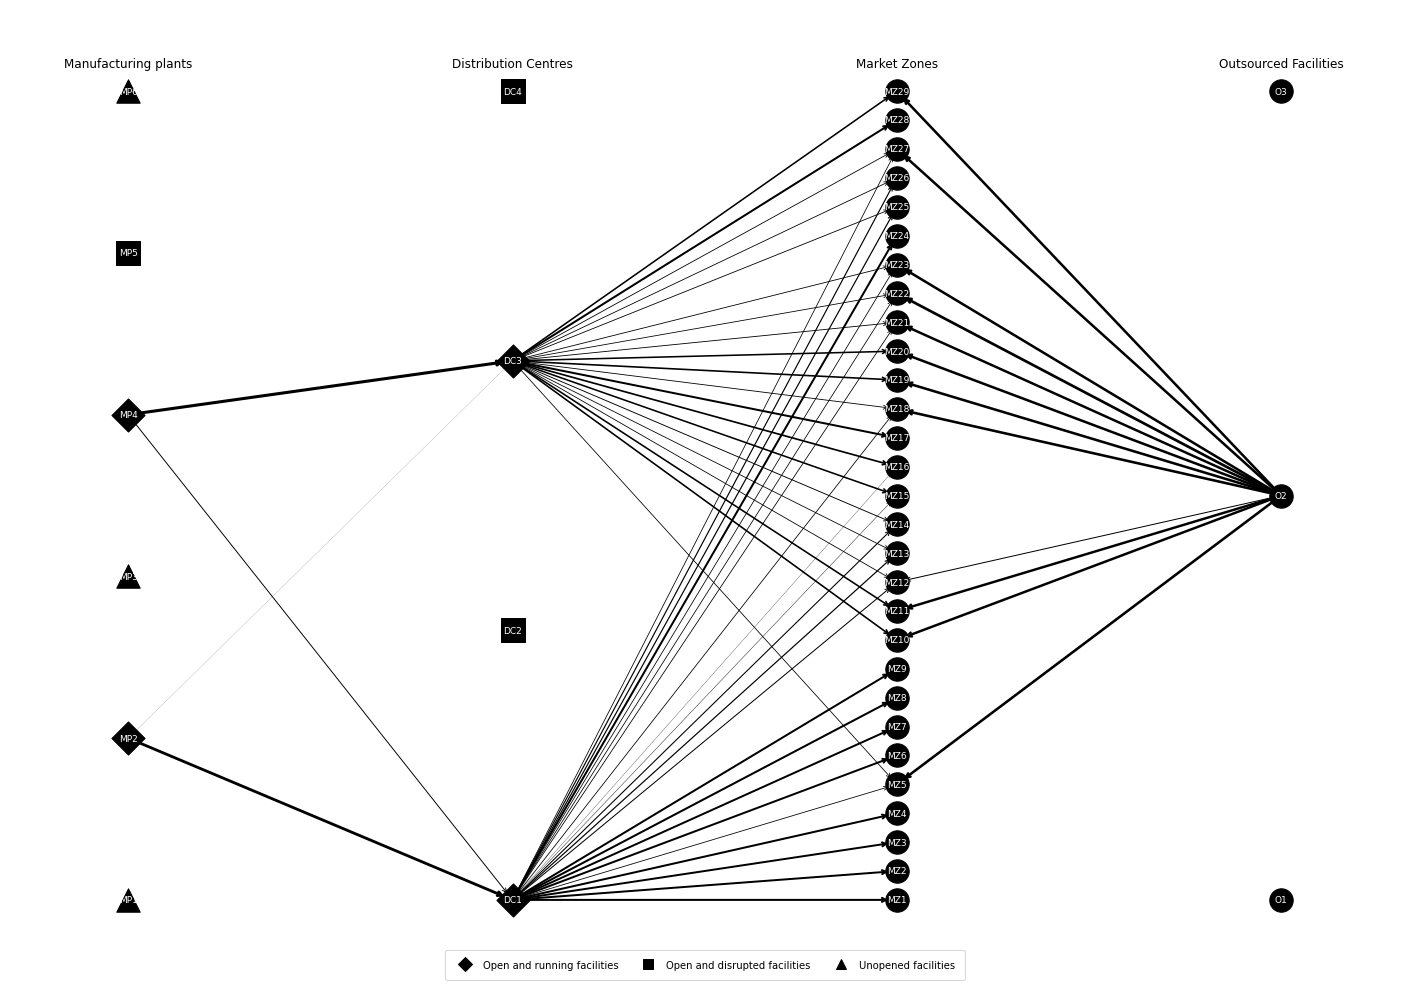

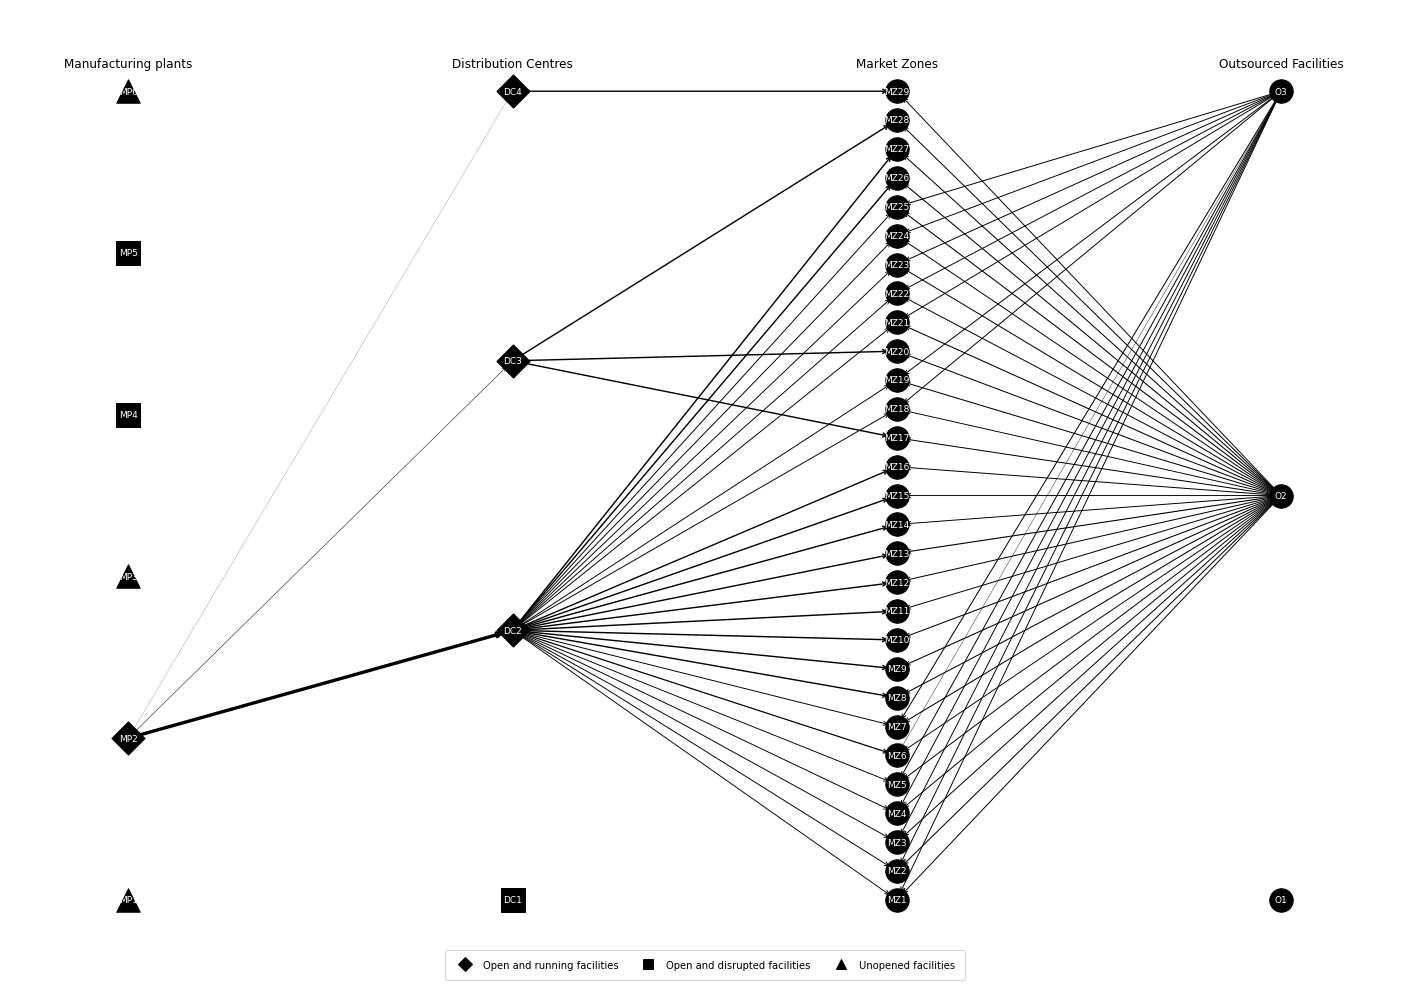

In [54]:
for index in indices:
    
    Y_mat = np.array(list(v_val_Y_ijm.values())).reshape(num_Scenarios, Products, Manufacturing_plants, Distribution)
    Z_mat = np.array(list(v_val_Z_jkm.values())).reshape(num_Scenarios, Products, Distribution, Market)
    T2_mat = np.array(list(v_val_T_lkm.values())).reshape(num_Scenarios, Products, Outsourced, Market)

    Y = sum(Y_mat[index])
    Z = sum(Z_mat[index])
    T2 = sum(T2_mat[index])

    MP = ["MP" + str(i+1) for i in range(Manufacturing_plants)]
    DC = ["DC" + str(j+1) for j in range(Distribution)]
    MZ = ["MZ" + str(k+1) for k in range(Market)]
    O = ["O" + str(l+1) for l in range(Outsourced)]

    Position_dic = {}
    Node_shapes = []
    Edge_colors = []
    Node_size = []
    Weight = []
    Weight_ij = []
    Weight_jk = []
    Weight_lk = []
    Max_p = max(Manufacturing_plants, Distribution, Market, Outsourced)

    IJ_edges = []
    for i in range(Manufacturing_plants):
        for j in range(Distribution):
            #if Y[i][j] > 0:
            IJ_edges.append(("MP" + str(i+1), "DC" + str(j+1)))    
    Weight_ij.extend(Y.sum(axis=1))
        
    JK_edges = []
    for j in range(Distribution):
        for k in range(Market):
            #if Z[j][k] > 0:
            JK_edges.append(("DC" + str(j+1), "MZ" + str(k+1)))
    Weight_jk.extend(Z.sum(axis=1))

    LK_edges = []
    for l in range(Outsourced):
        for k in range(Market):
            #if Tlk[l][k] > 0:
            LK_edges.append(("O" + str(l+1), "MZ" + str(k+1)))    
    Weight_lk.extend(T2.sum(axis = 1))

    Weight.extend([4*Y[i][j]/max(Weight_ij) for i in range(Manufacturing_plants) for j in range(Distribution)])
    Weight.extend([29*Z[j][k]/max(Weight_jk) for j in range(Distribution) for k in range(Market)])
    Weight.extend([29*T2[l][k]/max(Weight_lk) for l in range(Outsourced) for k in range(Market)])        

                
    Graph = nx.DiGraph()

    Position_values = []
    y_pos = np.linspace(0, Max_p, Manufacturing_plants)
    for i in range(Manufacturing_plants):
        position = (0, y_pos[i])        
        if v_val_x_i[i] == 1 and Scen[index][0][i] == 1:
            Graph.add_node(MP[i], s="D")
        elif v_val_x_i[i] == 1 and Scen[index][0][i] == 0:
            Graph.add_node(MP[i], s="s")
        else:
            Graph.add_node(MP[i], s="^")
        Position_values.append(np.asarray(position))
    Position_dic = dict(zip(MP, Position_values))

    Position_values = []
    y_pos = np.linspace(0, Max_p, Distribution)
    for j in range(Distribution):
        position = (1, y_pos[j])
        Graph.add_node(DC[j])
        if v_val_x_j[j] == 1 and Scen[index][1][j] == 1:
            Graph.add_node(DC[j], s="D")
        elif v_val_x_j[j] == 1 and Scen[index][1][j] == 0:
            Graph.add_node(DC[j], s="s")
        else:
            Graph.add_node(DC[j], s="^")
        Position_values.append(np.asarray(position))
    Position_dic.update(dict(zip(DC, Position_values)))

    Position_values = []
    y_pos = np.linspace(0, Max_p, Market)
    for k in range(Market):
        position = (2, y_pos[k])
        Graph.add_node(MZ[k], s = 'o')
        Position_values.append(np.asarray(position))
    Position_dic.update(dict(zip(MZ, Position_values)))

  
    Position_values = []
    y_pos = np.linspace(0, Max_p, Outsourced)
    for l in range(Outsourced):
        position = (3, y_pos[l])
        Graph.add_node(O[l], s = 'o')
        Position_values.append(np.asarray(position))
    Position_dic.update(dict(zip(O, Position_values)))

    #labels = {}    
    #for node in Graph.nodes():
     #   labels[node] = node

    nodeShapes = set((aShape[1]["s"] for aShape in Graph.nodes(data = True)))
    for aShape in nodeShapes:
    #...filter and draw the subset of nodes with the same symbol in the positions that are now known through the use of the layout.
        nx.draw_networkx_nodes(Graph,Position_dic,node_shape = aShape, nodelist = [sNode[0] for sNode in filter(lambda x: x[1]["s"]==aShape,Graph.nodes(data = True))],node_size=550, node_color= "black")


    # Add Edges

    Graph.add_edges_from(IJ_edges)
    Graph.add_edges_from(JK_edges)
    Graph.add_edges_from(LK_edges)


    nodePos = nx.shell_layout(Graph)
    nx.draw_networkx_edges(Graph, edge_color = "black", pos = Position_dic, width = Weight, arrows=True, arrowstyle = '->')
    nx.draw_networkx_labels(Graph, pos = Position_dic, font_color = "white", font_size = 9)

    # Add Titles (invisible nodes to put text labels)
    position_mp = (0, 30)
    position_dc = (1, 30)
    position_mz = (2, 30)
    position_o = (3, 30)
    position_titles = [np.asarray(position_mp), np.asarray(position_dc), np.asarray(position_mz), np.asarray(position_o)]
    Graph.add_node("Manufacturing Plants")
    Graph.add_node("Distribution Centres")
    Graph.add_node("Market Zones")
    Graph.add_node("Outsourced Facilities")
    titles = ["Manufacturing plants", "Distribution Centres", "Market Zones", "Outsourced Facilities"]
    title_pos = dict(zip(titles, position_titles))
    label_titles = {}    
    for node in titles:
        label_titles[node] = node
    nx.draw_networkx_nodes(Graph, nodelist= titles, pos = title_pos, node_color = "white")
    nx.draw_networkx_labels(Graph, labels = label_titles, pos = title_pos, font_color = "black", font_size = 12)


    limits=plt.axis('off')
    plt.gcf().set_size_inches(25, 18)

    diamond = mlines.Line2D([], [], linewidth = 0, color='black', marker='D',
                          markersize=10, label='Open and running facilities')
    
    square = mlines.Line2D([], [], linewidth = 0, color='black', marker='s',
                          markersize=10, label='Open and disrupted facilities')

    triangle = mlines.Line2D([], [], linewidth = 0, color='black', marker='^',
                          markersize=10, label='Unopened facilities')
      

    ax = plt.subplot(111)
    ax.legend(loc = 'lower center', handles=[diamond, square, triangle], ncol = 3, borderpad=1)

    plt.show()

In [46]:
nodeShapes = set((aShape[1]["s"] for aShape in Graph.nodes(data = True)))
[sNode[0] for sNode in filter(lambda x: x[1]["s"]==aShape,Graph.nodes(data = True))]

KeyError: 's'

In [41]:
position_mp = (0, 0.1)
position_dc = (1, 0.1)
position_mz = (2, 0.1)
position_o = (3, 0.1)
position_titles = [np.asarray(position_mp), np.asarray(position_dc), np.asarray(position_mz), np.asarray(position_o)]
Graph.add_node("Manufacturing Plants")
Graph.add_node("Distribution Centres")
Graph.add_node("Market Zones")
Graph.add_node("Outsourced Facilities")
titles = ["Manufacturing plants", "Distribution Centres", "Market Zones", "Outsourced Facilities"]
title_pos = dict(zip(titles, position_titles))

{'Manufacturing plants': array([ 0. , 29.1]),
 'Distribution Centres': array([ 1. , 29.1]),
 'Market Zones': array([ 2. , 29.1]),
 'Outsourced Facilities': array([ 3. , 29.1])}

# Instance 2

In [101]:
r_level = 0.5
demand = np.loadtxt('/home/dkabe/Model_brainstorming/Input_Data/Realistic/Instance_2/Demand_2.txt').reshape((300, 3, 29))
text_file = open('/home/dkabe/Model_brainstorming/Input_Data/Realistic/Instance_2/scen_2.txt', "r")
ls = text_file.read().split('\n')[:-1]
Scen = list(map(lambda x: ast.literal_eval(x), ls))
f = open(path + "Instance_2/variable_vals_" +str(r_level) + ".txt", "r")
text = f.read()
f.close()
solutions_str = text.split('\n')
for i in solutions_str:
    exec(i.lstrip().rstrip())
num_Scenarios = 300


In [102]:
print(v_val_x_i)
print(v_val_x_j)


{0: -0.0, 1: 1.0, 2: 1.0, 3: -0.0, 4: 1.0, 5: 1.0}
{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}


In [103]:
indices = [0, 3]
for index in indices:
    print(Scen[index])

[[0, 0, 1, 1, 1, 0], (1, 0, 1, 1)]
[[1, 0, 0, 1, 0, 1], (0, 0, 0, 1)]


/home/dkabe/env_gurobi/lib/python3.7/site-packages/ipykernel_launcher.py:130: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


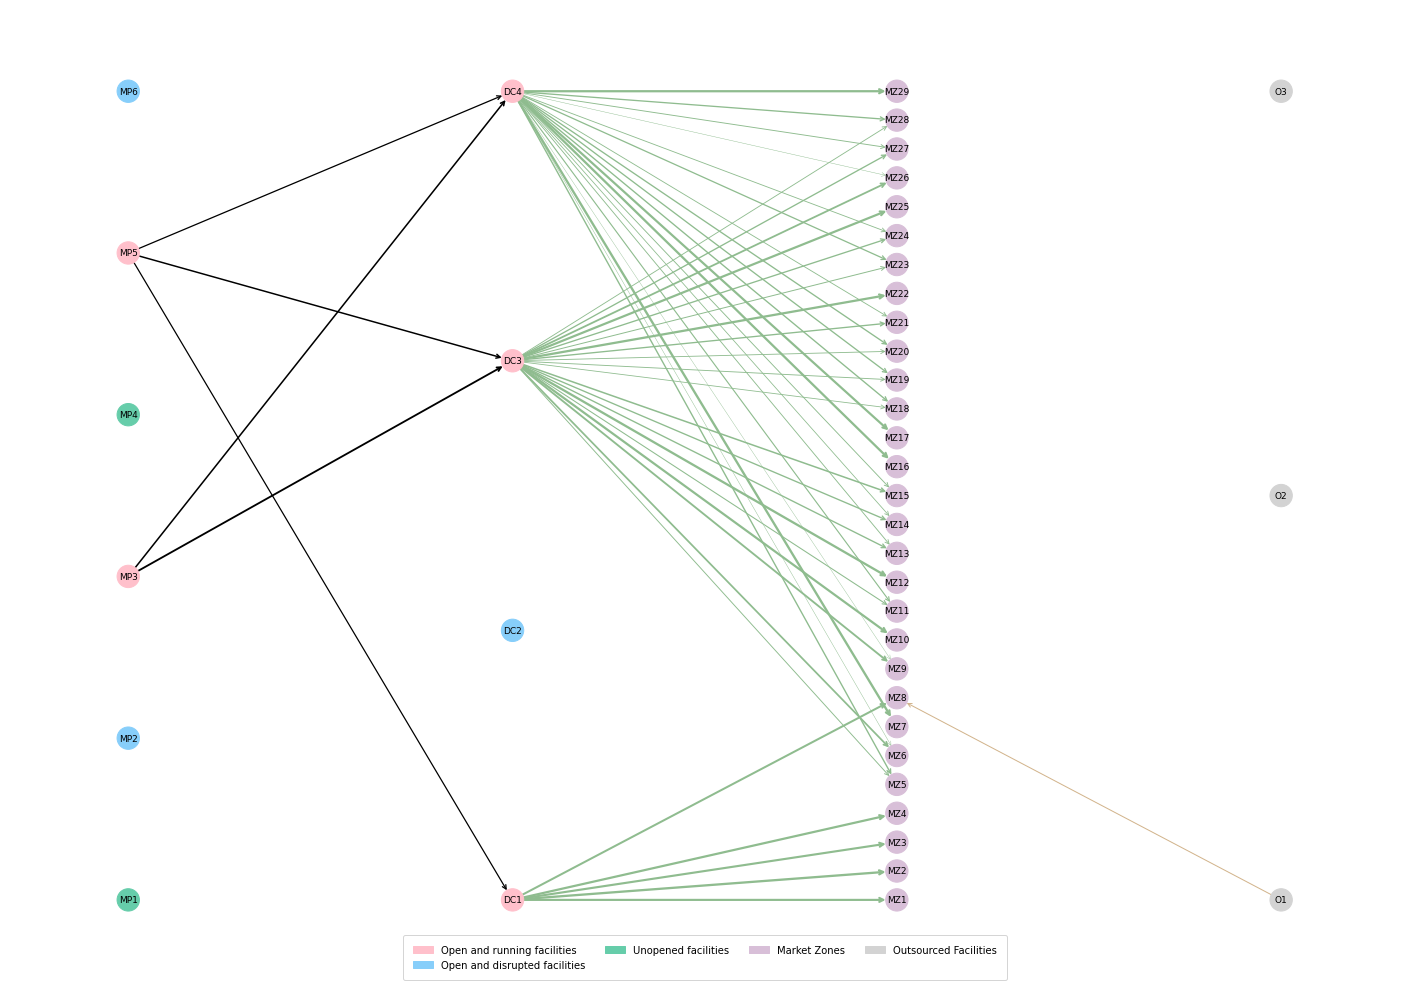

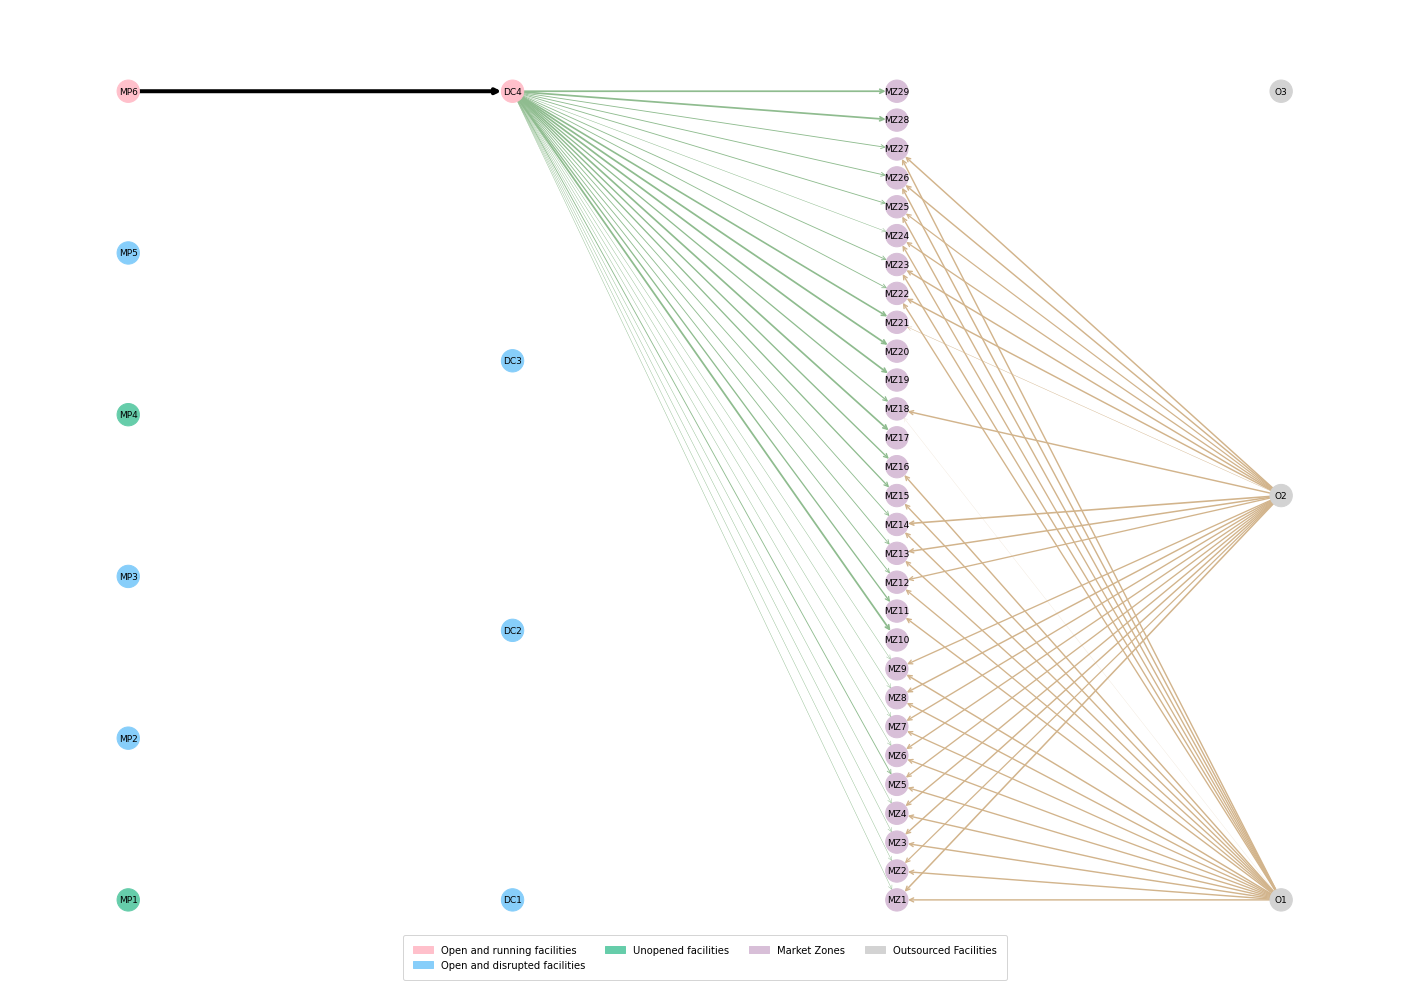

In [104]:
for index in indices:
    
    Y_mat = np.array(list(v_val_Y_ijm.values())).reshape(num_Scenarios, Products, Manufacturing_plants, Distribution)
    Z_mat = np.array(list(v_val_Z_jkm.values())).reshape(num_Scenarios, Products, Distribution, Market)
    T2_mat = np.array(list(v_val_T_lkm.values())).reshape(num_Scenarios, Products, Outsourced, Market)

    Y = sum(Y_mat[index])
    Z = sum(Z_mat[index])
    T2 = sum(T2_mat[index])

    MP = ["MP" + str(i+1) for i in range(Manufacturing_plants)]
    DC = ["DC" + str(j+1) for j in range(Distribution)]
    MZ = ["MZ" + str(k+1) for k in range(Market)]
    O = ["O" + str(l+1) for l in range(Outsourced)]

    Position_dic = {}
    Node_colors = []
    Edge_colors = []
    Node_size = []
    Weight = []
    Weight_ij = []
    Weight_jk = []
    Weight_lk = []
    Max_p = max(Manufacturing_plants, Distribution, Market, Outsourced)

    IJ_edges = []
    for i in range(Manufacturing_plants):
        for j in range(Distribution):
            #if Y[i][j] > 0:
            IJ_edges.append(("MP" + str(i+1), "DC" + str(j+1)))    
    Weight_ij.extend(Y.sum(axis=1))
        
    JK_edges = []
    for j in range(Distribution):
        for k in range(Market):
            #if Z[j][k] > 0:
            JK_edges.append(("DC" + str(j+1), "MZ" + str(k+1)))
    Weight_jk.extend(Z.sum(axis=1))

    LK_edges = []
    for l in range(Outsourced):
        for k in range(Market):
            #if Tlk[l][k] > 0:
            LK_edges.append(("O" + str(l+1), "MZ" + str(k+1)))    
    Weight_lk.extend(T2.sum(axis = 1))

    Weight.extend([4*Y[i][j]/max(Weight_ij) for i in range(Manufacturing_plants) for j in range(Distribution)])
    Weight.extend([29*Z[j][k]/max(Weight_jk) for j in range(Distribution) for k in range(Market)])
    for l in range(Outsourced):
            for k in range(Market):
                if T2[l][k]/max(Weight_lk) < 1:
                    Weight.append(29*T2[l][k]/max(Weight_lk))
                else:
                    Weight.append(T2[l][k]/max(Weight_lk))
                
    Graph = nx.DiGraph()

    Position_values = []
    y_pos = np.linspace(0, Max_p, Manufacturing_plants)
    for i in range(Manufacturing_plants):
        position = (0, y_pos[i])        
        Graph.add_node(MP[i])
        if v_val_x_i[i] == 1 and Scen[index][0][i] == 1:
            Node_colors.append('pink')
        elif v_val_x_i[i] == 1 and Scen[index][0][i] == 0:
            Node_colors.append('lightskyblue')
        else:
            Node_colors.append("mediumaquamarine")
        Position_values.append(np.asarray(position))
    Position_dic = dict(zip(MP, Position_values))

    Position_values = []
    y_pos = np.linspace(0, Max_p, Distribution)
    for j in range(Distribution):
        position = (1, y_pos[j])
        Graph.add_node(DC[j])
        if v_val_x_j[j] == 1 and Scen[index][1][j] == 1:
            Node_colors.append('pink')
        elif v_val_x_j[j] == 1 and Scen[index][1][j] == 0:
            Node_colors.append('lightskyblue')
        else:
            Node_colors.append("mediumaquamarine")
        Position_values.append(np.asarray(position))
    Position_dic.update(dict(zip(DC, Position_values)))

    Position_values = []
    y_pos = np.linspace(0, Max_p, Market)
    for k in range(Market):
        position = (2, y_pos[k])
        Graph.add_node(MZ[k])
        Node_colors.append('thistle')
        Position_values.append(np.asarray(position))
    Position_dic.update(dict(zip(MZ, Position_values)))

  
    Position_values = []
    y_pos = np.linspace(0, Max_p, Outsourced)
    for l in range(Outsourced):
        position = (3, y_pos[l])
        Graph.add_node(O[l])
        Node_colors.append('lightgrey')
        Position_values.append(np.asarray(position))
    Position_dic.update(dict(zip(O, Position_values)))

    # Add Edges

    Graph.add_edges_from(IJ_edges)
    Graph.add_edges_from(JK_edges)
    Graph.add_edges_from(LK_edges)


    Edge_colors.extend(['black' for i in IJ_edges])
    Edge_colors.extend(['darkseagreen' for i in JK_edges])
    Edge_colors.extend(['tan' for l in LK_edges])


    nodePos = nx.shell_layout(Graph)
    nx.draw_networkx(Graph, with_labels = True, font_size = 9, font_color = "black", node_size = 500, node_color = Node_colors, edge_color = Edge_colors, pos = Position_dic, width = Weight, arrows=True, arrowstyle = '->')


    limits=plt.axis('off')
    plt.gcf().set_size_inches(25, 18)

    legend_mp_1 = mpatches.Patch(color = 'pink', label = 'Open and running facilities')
    legend_mp_2 = mpatches.Patch(color = 'lightskyblue', label = 'Open and disrupted facilities')
    legend_mp_3 = mpatches.Patch(color = 'mediumaquamarine', label = 'Unopened facilities')
    legend_mz = mpatches.Patch(color = 'thistle', label = 'Market Zones')
    legend_o = mpatches.Patch(color = 'lightgrey', label = 'Outsourced Facilities')

    ax = plt.subplot(111)
    ax.legend(loc = 'lower center', handles=[legend_mp_1, legend_mp_2, legend_mp_3, legend_mz, legend_o], ncol = 4, borderpad=1)

    plt.show()